In [25]:
import json, sys, os

sys.path.insert(1, "../..")
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot

import matplotlib.pyplot as plt
import seaborn as sns
import smart_open
import shap
from src.utils import deposit_v1_scale_score, build_score_coefficients, scale_ach_v2_dev, scale_ach_v2_refit

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# modeling_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_modeling_df_refit.parquet')
test_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_test_df_refit.parquet')

<AxesSubplot:>

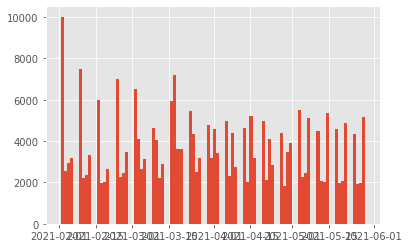

In [3]:
test_df.transaction_datetime.hist(bins=100)

In [26]:
test_df["deposit_v1_score"] = deposit_v1_scale_score(test_df["deposit_v1_pred"])

test_df["deposit_v2_ach_refit_pred"] = test_df["score"] / 100
test_df["ach_v2_score_refit"] = scale_ach_v2_refit(test_df["deposit_v2_ach_refit_pred"])

test_df["deposit_v2_ach_dev_final_pred"]
test_df["ach_v2_score_dev"] = scale_ach_v2_dev(test_df["deposit_v2_ach_dev_final_pred"])

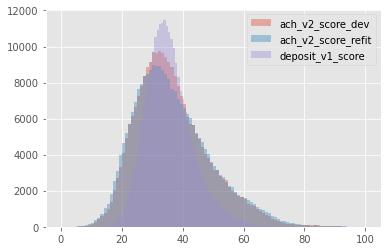

In [27]:
test_df["ach_v2_score_dev"].hist(bins=100, alpha=0.4, legend="ach_v2_dev")
test_df["ach_v2_score_refit"].hist(bins=100, alpha=0.4, legend="ach_v2_refit")
test_df["deposit_v1_score"].hist(bins=100, alpha=0.4, legend="deposit_v1")
plt.show()

(<Figure size 1152x432 with 2 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

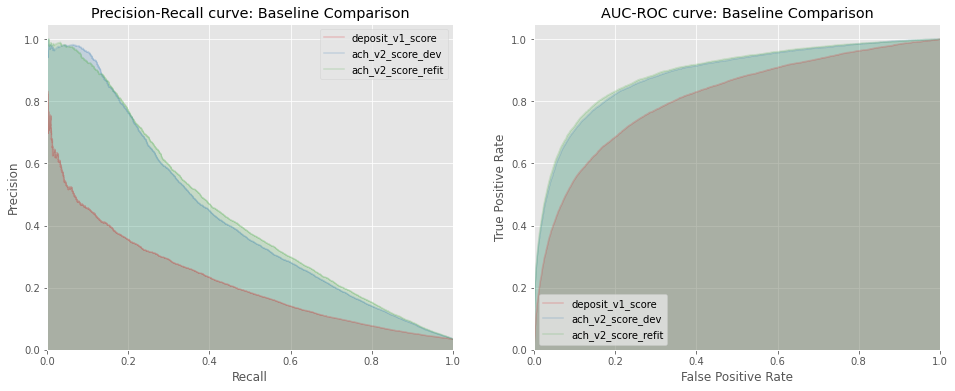

In [32]:
# last check the preformance is correct before sending it over
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

target_col = "is_returned"
pred_cols_all = ['deposit_v1_score', 
             'ach_v2_score_dev',
             'ach_v2_score_refit']

preds = [(test_df[col], col) for col in pred_cols_all]

fig, axs = plt.subplots(1, 2, figsize=(16,6))
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[1], fig=fig)

In [33]:
test_df.transaction_datetime.describe()

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                  257328
unique                    839
top       2021-03-15 18:01:11
freq                     1123
first     2021-02-01 18:01:07
last      2021-05-28 18:01:12
Name: transaction_datetime, dtype: object

In [34]:
test_df.columns

Index(['index', 'transaction_datetime', 'tjd', 'tseq', 'time',
       'business_account_number', 'trnx_created_dt', 'endbal',
       'transaction_code', 'transaction_comment',
       ...
       'deposit_v1_pred', 'customer_pred', 'deposit_v2_ach_dev_final_pred',
       'customer_refit_2021Q1_pred', 'pred', 'score',
       'deposit_v2_ach_refit_pred', 'deposit_v1_score', 'ach_v2_score_refit',
       'ach_v2_score_dev'],
      dtype='object', length=264)

In [44]:
meta_cols = ["business_account_number", "user_id",
             "is_returned", "transaction_datetime",
             "transaction_amount", "transaction_code"]
pred_cols = ['deposit_v1_score', 
             'ach_v2_score_dev',
             'ach_v2_score_refit',
             'customer_pred',
             'customer_refit_2021Q1_pred']
cols = meta_cols + pred_cols
test_df[cols].head()

,business_account_number,user_id,is_returned,transaction_datetime,transaction_amount,transaction_code,deposit_v1_score,ach_v2_score_dev,ach_v2_score_refit,customer_pred,customer_refit_2021Q1_pred
0,410000070641,3599351,False,2021-02-12 18:01:06,120.00,ACHDD,43.039025,30.752501,34.248931,0.012067,0.014702
1,410000070641,3599351,False,2021-02-26 18:01:06,120.00,ACHDD,42.981044,31.698147,37.345017,0.004204,0.011017
2,410000070641,3599351,False,2021-03-12 18:01:06,120.00,ACHDD,43.120645,31.698147,37.345017,0.012168,0.005800
3,410000070650,3804717,False,2021-02-04 18:01:06,72.82,ACHDD,33.210156,20.400512,24.202479,0.003358,0.003370
4,410000070650,3804717,False,2021-02-12 18:01:06,120.00,ACHDD,33.701944,21.754000,24.816478,0.003292,0.002530


In [45]:
test_df[pred_cols].describe()

,deposit_v1_score,ach_v2_score_dev,ach_v2_score_refit,customer_pred,customer_refit_2021Q1_pred
count,257328.000000,257328.000000,257328.000000,257328.000000,257328.000000
mean,35.626184,36.655545,36.772411,0.126396,0.143048
std,7.748807,12.087334,12.760765,0.230584,0.219578
min,8.647131,0.000000,0.000000,0.000013,0.000233
25%,30.312545,28.068112,27.491137,0.002321,0.010184
50%,34.746165,34.878043,34.852749,0.014039,0.037222
75%,39.922238,43.537229,44.252273,0.118903,0.170289
max,84.517783,100.000000,100.000000,0.999603,0.999576


In [46]:
test_df[cols].to_csv("../../artifacts/ach-mc-refit/ach-v2-preds-202102-202105.csv")